<a href="https://colab.research.google.com/github/DeJezuz/AI-Ethics-Assignment/blob/main/compas_audit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install aif360
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Ensure the data directory exists and download the COMPAS dataset if not present
data_path = '/usr/local/lib/python3.12/dist-packages/aif360/data/raw/compas'
file_path = os.path.join(data_path, 'compas-scores-two-years.csv')

if not os.path.exists(data_path):
    os.makedirs(data_path)

if not os.path.exists(file_path):
    print(f"Downloading {os.path.basename(file_path)}...")
    !wget -q -O {file_path} https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv
    print(f"{os.path.basename(file_path)} downloaded.")
else:
    print(f"{os.path.basename(file_path)} already exists.")

from aif360.datasets import CompasDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing import Reweighing
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Load COMPAS dataset
compas = CompasDataset()
privileged_groups = [{'race': 1}]   # Non-African-American
unprivileged_groups = [{'race': 0}] # African-American

# Train/test split
train, test = compas.split([0.7], shuffle=True)

compas-scores-two-years.csv downloaded.


In [5]:
bdm_train = BinaryLabelDatasetMetric(train,
                                     unprivileged_groups=unprivileged_groups,
                                     privileged_groups=privileged_groups)
print("Training disparate impact:", bdm_train.disparate_impact())

Training disparate impact: 0.848766836004271


In [7]:
clf = Pipeline([
    ('scaler', StandardScaler(with_mean=False)),
    ('lr', LogisticRegression(max_iter=1000))
])
clf.fit(train.features, train.labels.ravel())
y_pred = clf.predict(test.features)

test_pred = test.copy(deepcopy=True)
test_pred.labels = y_pred.reshape(-1, 1)

cm = ClassificationMetric(test, test_pred,
                          unprivileged_groups=unprivileged_groups,
                          privileged_groups=privileged_groups)

print("Disparate impact:", BinaryLabelDatasetMetric(test_pred,
                                                  unprivileged_groups=unprivileged_groups,
                                                  privileged_groups=privileged_groups).disparate_impact())
print("Equal opportunity difference:", cm.equal_opportunity_difference())
print("Average odds difference:", cm.average_odds_difference())
print("Statistical parity difference:", cm.statistical_parity_difference())

Disparate impact: 0.8004678593786037
Equal opportunity difference: -0.049823697048736904
Average odds difference: -0.11717900229945874
Statistical parity difference: -0.1401365266689807


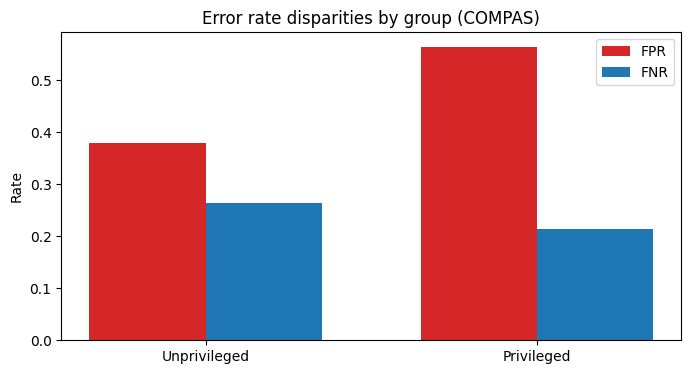

In [13]:
groups = ['Unprivileged', 'Privileged']
fprs = [cm.false_positive_rate(False), cm.false_positive_rate(True)]
fnrs = [cm.false_negative_rate(False), cm.false_negative_rate(True)]

plt.figure(figsize=(8,4))
bar_width = 0.35
idx = np.arange(len(groups))
plt.bar(idx, fprs, bar_width, label='FPR', color='#d62728')
plt.bar(idx + bar_width, fnrs, bar_width, label='FNR', color='#1f77b4')
plt.xticks(idx + bar_width/2, groups)
plt.ylabel('Rate')
plt.title('Error rate disparities by group (COMPAS)')
plt.legend()
plt.show()

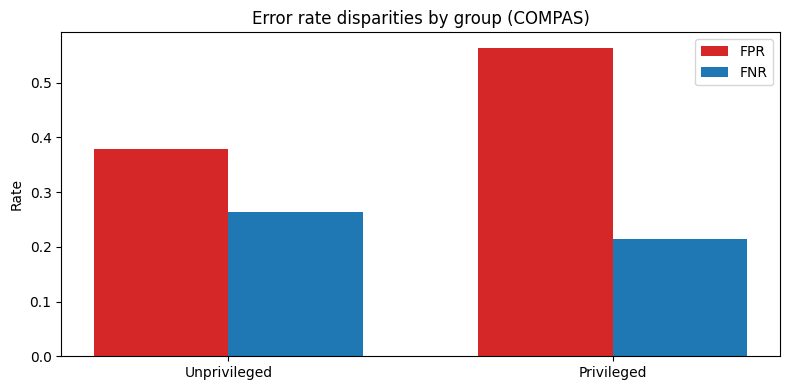

In [14]:
plt.figure(figsize=(8,4))
bar_width = 0.35
idx = np.arange(len(groups))
plt.bar(idx, fprs, bar_width, label='FPR', color='#d62728')
plt.bar(idx + bar_width, fnrs, bar_width, label='FNR', color='#1f77b4')
plt.xticks(idx + bar_width/2, groups)
plt.ylabel('Rate')
plt.title('Error rate disparities by group (COMPAS)')
plt.legend()
plt.tight_layout()

# Save figure
plt.savefig("error_rate_disparities.png", dpi=300)
plt.show()

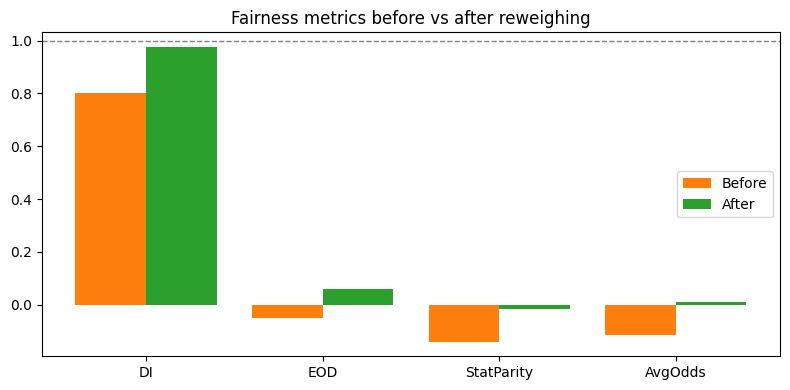

In [16]:
di = 0.8004678593786037
eod = -0.049823697048736904
avg_odds = -0.11717900229945874
stat_parity = -0.1401365266689807

di_rw = 0.9758226411800646
eod_rw = 0.05878375114717671
avg_odds_rw = 0.011167301793459011
stat_parity_rw = -0.014956226618843771

labels = ['DI', 'EOD', 'StatParity', 'AvgOdds']
before = [di, eod, stat_parity, avg_odds]
after = [di_rw, eod_rw, stat_parity_rw, avg_odds_rw]

plt.figure(figsize=(8,4))
x = np.arange(len(labels))
plt.bar(x - 0.2, before, width=0.4, label='Before', color='#ff7f0e')
plt.bar(x + 0.2, after, width=0.4, label='After', color='#2ca02c')
plt.xticks(x, labels)
plt.axhline(1.0, color='gray', linestyle='--', linewidth=1)  # DI target ~1
plt.title('Fairness metrics before vs after reweighing')
plt.legend()
plt.tight_layout()

# Save figure
plt.savefig("fairness_metrics_comparison.png", dpi=300)
plt.show()

### Graphique: Comparaison des métriques d'équité avant et après le rééquilibrage

![Fairness Metrics Comparison](fairness_metrics_comparison.png)

### Graphique: Taux d'erreur par groupe (COMPAS)

![Error Rate Disparities](error_rate_disparities.png)